In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as f:
        data_dict = pickle.load(f, encoding='bytes')
    return data_dict


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from customDataLoader import CIFAR_DataLoader
import numpy as np

# CIFAR-10 데이터셋 로드
cifar_dir = os.getcwd()  # 현재 작업 디렉토리 가져오기
print(cifar_dir)

train_images_list = []
train_labels_list = []

# 훈련 데이터 로드
for batch_number in range(1, 5):
    train_batch_file = os.path.join(cifar_dir, 'cifar-10-batches-py', f'data_batch_{batch_number}')
    train_data = unpickle(train_batch_file)
    train_images_list.append(train_data[b'data'])
    train_labels_list.append(train_data[b'labels'])
    
train_images = np.vstack(train_images_list)
train_labels = np.hstack(train_labels_list)
train_images = train_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
# train_images -> train_images.reshape()을 한 뒤 디버깅을 해보기
print(train_images.shape)
print(train_labels.shape)
# 테스트 데이터 로드
test_batch_file = os.path.join(cifar_dir, 'cifar-10-batches-py', 'test_batch')
test_data = unpickle(test_batch_file)
test_images = test_data[b'data']
test_labels = test_data[b'labels']
test_images = test_images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

# 데이터셋 및 데이터로더 설정
train_dataset = CIFAR_DataLoader(train_images, train_labels)
test_dataset = CIFAR_DataLoader(test_images, test_labels)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False, drop_last=False)

# CIFAR-10의 클래스
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


/Users/SaintKim/Python/Artificial_Intelligence/Deep_Learning/CIFAR_10
(40000, 32, 32, 3)
(40000,)


In [2]:
# CIAFR-10 이미지는 32x32크기
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # (16, 32, 32)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # (32, 32, 32)
        self.pool = nn.MaxPool2d(2, 2) # (32, 16, 16)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [5]:
def train(model, train_data, optimizer, log_interval, epoch):
    model.train()
    for batch_idx, (images, labels) in enumerate(train_data):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
    if batch_idx % log_interval == 0:
        print(f"[Train Loss: {loss.item():.4f}]")


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(images, labels, predictions, classes):
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.flatten()
    
    for img, label, pred, ax in zip(images, labels, predictions, axes):
        img = img / 2 + 0.5  # 정규화된 이미지를 원래 범위로 변환
        npimg = img.numpy().transpose((1, 2, 0))
        ax.imshow(npimg)
        ax.set_title(f'True:{classes[label]} \n Pred: {classes[pred]}', fontsize=20)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


Matplotlib is building the font cache; this may take a moment.


32


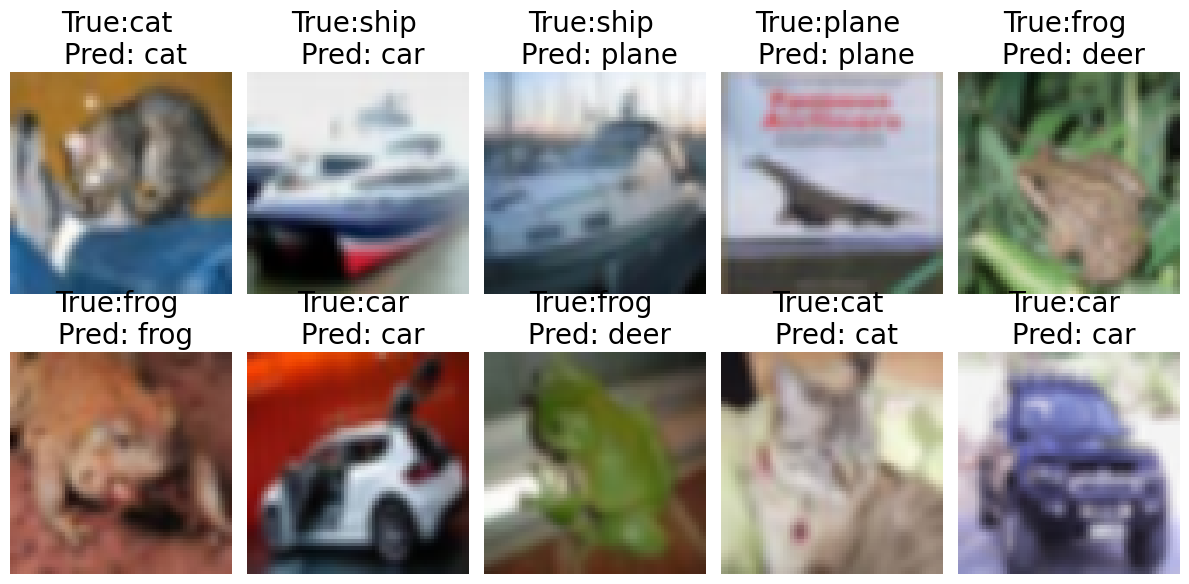


[epoch: 1]	Test Loss: 0.8566	Test Accuracy: 71.8750 % 



In [8]:
epochs = 1

for epoch in range(1, epochs+1):
    train(model, train_loader, optimizer, log_interval=1000, epoch=epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print(f"\n[epoch: {epoch}]\tTest Loss: {test_loss:.4f}\tTest Accuracy: {test_accuracy:.4f} % \n")
